# KnockoffScreen knockoffs

This is a tutorial for generating KnockoffScreen knockoffs for [genome-wide association studies](https://en.wikipedia.org/wiki/Genome-wide_association_study). This kind of knockoffs is designed for sequence data that have a lot of rare variants. The methodology is described in the following papers

> He, Zihuai, Linxi Liu, Chen Wang, Yann Le Guen, Justin Lee, Stephanie Gogarten, Fred Lu et al. "Identification of putative causal loci in whole-genome sequencing data via knockoff statistics." Nature communications 12, no. 1 (2021): 1-18.

> He, Zihuai, Yann Le Guen, Linxi Liu, Justin Lee, Shiyang Ma, Andrew C. Yang, Xiaoxia Liu et al. "Genome-wide analysis of common and rare variants via multiple knockoffs at biobank scale, with an application to Alzheimer disease genetics." The American Journal of Human Genetics 108, no. 12 (2021): 2336-2353

In particular, we generate:

```math
\begin{align*}
\hat{X}_j &= \hat{\beta_0} + \sum_{k \in B_j}\hat{\beta_k}X_k + \sum_{k \in B_j, k \le j - 1}\hat{\gamma_k}\tilde{X_k}\\
\hat{\epsilon} &= permute(X_j - \hat{X}_j)\\
\tilde{X}_j &= \hat{X}_j + \hat{\epsilon}
\end{align*}
```

where $B_j$ is a ball of variants near $j$ and $\hat{\beta}_k, \hat{\gamma}_k$ are estimated via least squares. 

In [1]:
# first load packages needed for this tutorial
using Revise
using SnpArrays
using Knockoffs
using Statistics
using Plots
using GLMNet
using Distributions
using Random
gr(fmt=:png);

## Step 0: Prepare example data

To illustrate we need example PLINK data, which are available in `Knockoffs/data/mouse.imputed.(bed/bim/fam)`

In [2]:
# Path to PLINK data
mouse_path = joinpath(normpath(Knockoffs.datadir()), "mouse.imputed")

"/Users/biona001/.julia/dev/Knockoffs/data/mouse.imputed"

## Step 1: Generate Knockoffs

Knockoffs are made using the wrapper function [full_knockoffscreen](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.full_knockoffscreen). An iterator format that streams knockoffs one by one is coming soon.

!!! warning

    The output of `full_knockoffscreen` is a dense `Float64` matrix, which requires $8np$ bytes of RAM. Do not call it on large PLINK files. 

In [3]:
@time X̃ = full_knockoffscreen(mouse_path, windowsize=50)

Generating knockoffs100%|███████████████████████████████| Time: 0:01:40


129.793232 seconds (74.18 M allocations: 34.660 GiB, 5.35% gc time, 23.10% compilation time)


1940×10150 Matrix{Float64}:
 -0.158027  -0.15993  -0.397849  …   0.663515   0.664671   0.668258
 -0.157256  -0.15993   1.07455       0.663515   0.664671   0.666508
  1.26416    1.2633    0.914503      0.663515   0.664671   0.669306
 -0.158079  -0.15993  -0.412851      0.663515   0.664671   0.667707
  1.2641     1.2633    1.05954      -1.17537   -1.17217   -1.16703
 -0.15979   -0.15993  -0.412641  …   0.663515   0.664671   0.66629
 -0.159042  -0.15993   0.258318      0.663515   0.664671   0.669239
 -0.158219  -0.15993   1.0255        0.663515   0.664671   0.665875
 -0.156292  -0.15993   1.07454       0.663515   0.664671   0.667836
  1.26493    1.2633    1.07325      -1.17537   -1.17217   -1.16801
  1.26685    1.2633    0.258326  …  -3.01425   -3.00901   -3.00042
 -0.157256  -0.15993  -0.397863      0.663515   0.664671   0.669154
  1.26332    1.2633    1.06682      -3.01425   -3.00901   -3.00326
  ⋮                              ⋱                        
  1.26412    1.2633    1.0803     

## Step 2: Examine knockoff statistics

Lets check if the knockoffs "make sense". For example, we can compare SNP 1 and its knockoff (which are very similar):

In [10]:
# import original genotypes into numeric matrix
X = convert(Matrix{Float64}, SnpArray(mouse_path * ".bed"), center=true, scale=true)

# compare SNP 1 with its knockoff
[X[:, 1] X̃[:, 1]]

1940×2 Matrix{Float64}:
 -0.159187  -0.158027
 -0.159187  -0.157256
  1.26396    1.26416
 -0.159187  -0.158079
  1.26396    1.2641
 -0.159187  -0.15979
 -0.159187  -0.159042
 -0.159187  -0.158219
 -0.159187  -0.156292
  1.26396    1.26493
  1.26396    1.26685
 -0.159187  -0.157256
  1.26396    1.26332
  ⋮         
  1.26396    1.26412
  1.26396    1.26589
 -0.159187  -0.158027
 -0.159187  -0.158219
  1.26396    1.26493
 -0.159187  -0.158306
  1.26396    1.26589
 -0.159187  -0.158023
 -0.159187  -0.15899
 -0.159187  -0.159269
 -0.159187  -0.156292
 -1.58233   -1.58241

Lets also compare $cor(X_i, X_j)$ and $cor(X_i, \tilde{X}_j)$. If knockoffs satisfy exchangability, their correlation should be very similar and form a diagonal line. 

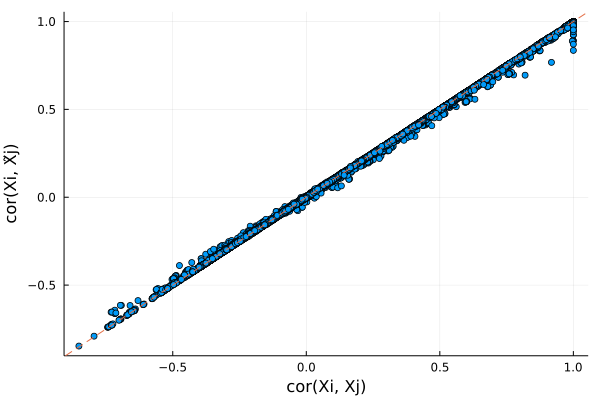

In [11]:
# look at pairwise correlation (between first 200 snps)
r1, r2 = Float64[], Float64[]
for i in 1:200, j in 1:i
    push!(r1, cor(@view(X[:, i]), @view(X[:, j])))
    push!(r2, cor(@view(X[:, i]), @view(X̃[:, j])))
end

# make plot
scatter(r1, r2, xlabel = "cor(Xi, Xj)", ylabel="cor(Xi, X̃j)", legend=false)
Plots.abline!(1, 0, line=:dash)

Plots distribution of $cor(X_j, \tilde{X}_j)$ for all $j$. Ideally, we want $cor(X_j, \tilde{X}_j)$ to be small in magnitude (i.e. $X$ and $\tilde{X}$ is very different). Here the knockoffs are tightly correlated with the original genotypes, so they will likely have low power. 

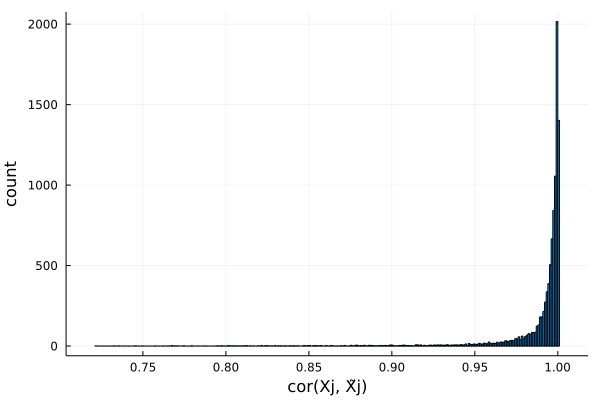

In [12]:
r2 = Float64[]
for j in 1:size(X, 2)
    push!(r1, cor(@view(X[:, j]), @view(X[:, j])))
    push!(r2, cor(@view(X[:, j]), @view(X̃[:, j])))
end
histogram(r2, legend=false, xlabel="cor(Xj, X̃j)", ylabel="count")

## LASSO example

Let us apply the generated knockoffs to the model selection problem. In layman's term, it can be stated as

> Given response $\mathbf{y}_{n \times 1}$, design matrix $\mathbf{X}_{n \times p}$, we want to select a subset $S \subset \{1,...,p\}$ of variables that are truly causal for $\mathbf{y}$. 

### Simulate data

We will simulate 

$$\mathbf{y}_{n \times 1} \sim N(\mathbf{X}_{n \times p}\mathbf{\beta}_{p \times 1} \ , \ \mathbf{\epsilon}_{n \times 1}), \quad \epsilon_i \sim N(0, 1)$$

where $k=50$ positions of $\mathbf{\beta}$ is non-zero with effect size $\beta_j \sim N(0, 1)$. The goal is to recover those 50 positions using LASSO.

In [13]:
# set seed for reproducibility
Random.seed!(999)

# simulate true beta
n, p = size(X)
k = 50
βtrue = zeros(p)
βtrue[1:k] .= randn(k)
shuffle!(βtrue)

# find true causal variables
correct_position = findall(!iszero, βtrue)

# simulate y
y = X * βtrue + randn(n);

### Standard LASSO

Lets try running standard LASSO, which will produce $\hat{\mathbf{\beta}}_{p \times 1}$ where we typically declare SNP $j$ to be selected if $\hat{\beta}_j \ne 0$. We use LASSO solver in [GLMNet.jl](https://github.com/JuliaStats/GLMNet.jl) package, which is just a Julia wrapper for the GLMnet Fortran code. 

How well does LASSO perform in terms of power and FDR?

In [14]:
# run 10-fold cross validation to find best λ minimizing MSE
lasso_cv = glmnetcv(X, y)
λbest = lasso_cv.lambda[argmin(lasso_cv.meanloss)]

# use λbest to fit LASSO on full data
βlasso = glmnet(X, y, lambda=[λbest]).betas[:, 1]

# check power and false discovery rate
power = length(findall(!iszero, βlasso) ∩ correct_position) / k
FDR = length(setdiff(findall(!iszero, βlasso), correct_position)) / count(!iszero, βlasso)

#summarize
count(!iszero, βlasso), power, FDR

(414, 0.78, 0.9057971014492754)

Observe that 

+ LASSO found a total of 414 SNPs
+ LASSO found $39/50 = 70$% of all true predictors
+ 375/364 SNPs were false positive (false discovery rate is 90%)

### Knockoff+LASSO

Now lets try applying the knockoff methodology. Recall that consists of a few steps 

1. Run LASSO on $[\mathbf{X} \mathbf{\tilde{X}}]$
2. Compare coefficient difference statistic $W_j$ for each $j = 1,...,p$. Here we use $W_j = |\beta_j| - |\beta_{j, knockoff}|$
3. Choose target FDR $0 \le q \le 1$ and compute 
$$\tau = min_{t}\left\{t > 0: \frac{{\#j: W_j ≤ -t}}{{\#j: W_j ≥ t}} \le q\right\}$$

!!! note
    
    In step 1, $[\mathbf{X} \mathbf{\tilde{X}}]$ is written for notational convenience. In practice one must interleave knockoffs with the original variables, where either the knockoff come first or the original genotype come first with equal probability. This is due to the inherent bias of LASSO solvers: when the original and knockoff variable are equally valid, the one listed first will be selected. 

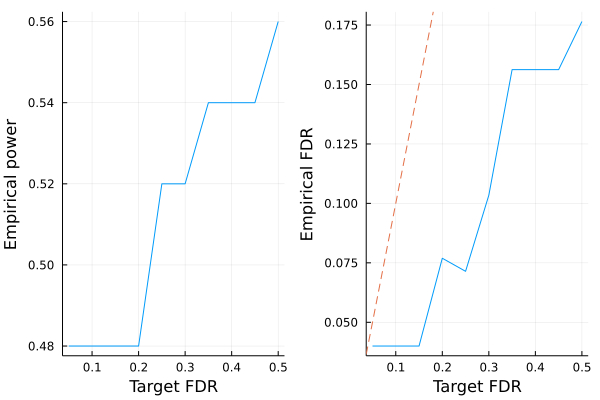

In [15]:
# interleave knockoffs with originals
Xfull, original, knockoff = merge_knockoffs_with_original(mouse_path,
    "knockoffs/mouse.imputed.fastphase.knockoffs",
    des="knockoffs/merged") 
Xfull = convert(Matrix{Float64}, Xfull, center=true, scale=true)

# step 1
knockoff_cv = glmnetcv(Xfull, y)                         # cross validation step
λbest = knockoff_cv.lambda[argmin(knockoff_cv.meanloss)] # find lambda that minimizes MSE
βestim = glmnet(Xfull, y, lambda=[λbest]).betas[:, 1]    # refit lasso with best lambda

# target FDR is 0.05, 0.1, ..., 0.5
FDR = collect(0.05:0.05:0.5)
empirical_power = Float64[]
empirical_fdr = Float64[]
for fdr in FDR
    βknockoff = extract_beta(βestim, fdr, original, knockoff) # steps 2-3 happen here

    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end

# visualize FDR and power
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylabel="Empirical power", legend=false)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylabel="Empirical FDR", legend=false)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

Observe that

+ LASSO + knockoffs controls the false discovery rate at below the target (dashed line)
+ Controlled FDR is compensated by slight loss of power

The empirical FDR should hug the target FDR more closely once we repeated the simulation multiple times and generate the knockoffs in a way so that they are not so correlated with the original genotypes. 